In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

import os
data_dir = 'data/Sketches/input_data/'

2023-04-20 10:07:41.188074: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-20 10:07:41.189552: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 10:07:41.216982: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-20 10:07:41.217507: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 10:07:41.638940: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
class RulerGenerator:
    def __init__(self, shape, line_width, lines, v_offset, raggedness, color, color_variation, angle):

        lines = lines or 12
        assert 0 <= raggedness <= 1
        assert 0 <= color <= 255
        assert 0 <= color_variation <= 255
        assert -180 <= angle <= 180
        assert 0 <= v_offset <= 1

        w, h = shape
        spacing = shape[1]//lines
        basis = np.array([0]*spacing + [1]*line_width).astype('uint8')
        column = np.tile(basis, 1+int(2*h/len(basis)))[0:2*h]
        lines_array = np.tile(column, 2*w).reshape(2*w, 2*h).T

        color_array = np.random.normal(
            size=(2*h, 2*w))*color_variation + color - color_variation/2
        color_array = color_array.astype('uint8')
        self.color_array = color_array

        ragged_array = 1*(np.random.random(size=(2*h, 2*w))
                          > raggedness).astype('uint8')

        lines_array *= color_array
        lines_array *= ragged_array
        l = 255 - lines_array
        color_offsets = np.random.randint(-60,60, 3)
        red = np.clip(np.where(l==255,255, l/3+color_offsets[0]), 0,255).astype('uint8')
        green = np.clip(np.where(l==255,255,l/3+color_offsets[1]),0,255).astype('uint8')
        blue = np.clip(np.where(l==255,255, l/3+color_offsets[2]),0,255).astype('uint8')
        
        RGB_array = np.stack([red,green,blue], axis =2)
        image = Image.fromarray(RGB_array, mode = 'RGB')
        
        image = image.rotate(angle)

        left = int(w/2)
        right = left + w
        top = int(h/2 + v_offset*len(basis))
        bottom = top + h

        self.image = image.crop((left, top, right, bottom))

In [3]:
def train_data():
    while True:
        i = np.random.choice(os.listdir(data_dir))
        i = Image.open(data_dir + i)
        j = ImageEnhance.Contrast(i).enhance(2)
        kwargs = {'shape': i.size,
          'line_width': np.random.randint(1,4),
          'lines': 20 + np.random.randint(-5,6),
          'v_offset': np.random.random(),
          'raggedness': .3 + np.random.random()/2,
          'color': np.random.randint(100, 150),
          'color_variation': np.random.randint(15, 30),
          'angle': np.random.randint(-10, 11)}
        rg = RulerGenerator(**kwargs)
        j = Image.blend(j, rg.image, .2)
        yield np.array(j).reshape(-1,500,500,3)/255,np.array(i).reshape(-1, 500,500,3)/255


        
        

In [15]:
X,Y = next(train_data())


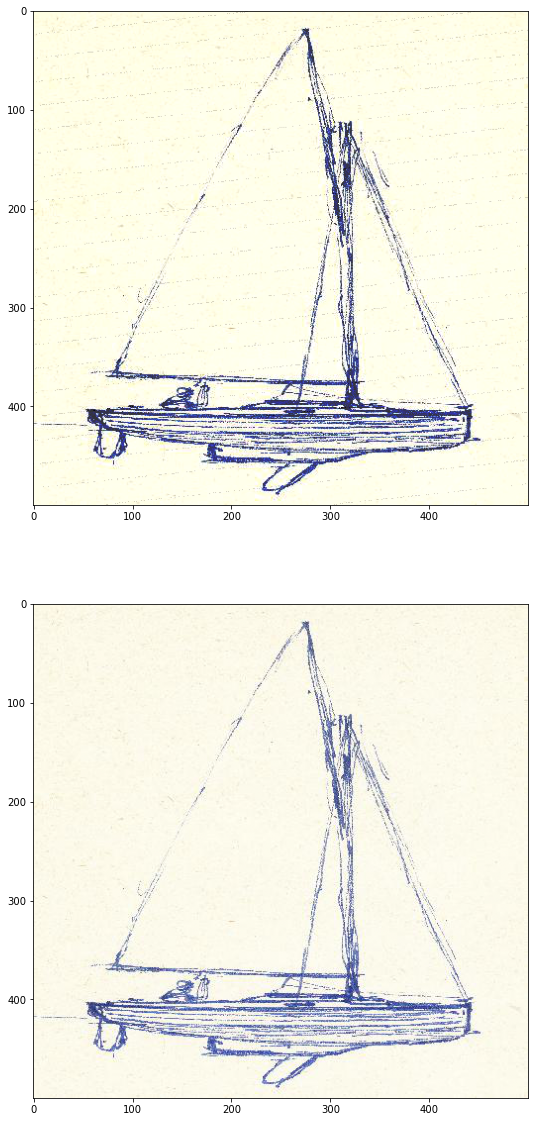

In [16]:
fig, axs = plt.subplots(2, figsize=(20,20))
axs[0].imshow(X[0])
axs[1].imshow(Y[0]);

In [17]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(500, 500, 3)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
history = autoencoder.fit(train_data(), steps_per_epoch=10, epochs=1000)

Epoch 1/1000


2023-04-20 10:09:51.247291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 1s 56ms/step - loss: 0.1821
Epoch 2/1000
10/10 [==============================] - 1s 55ms/step - loss: 0.1826
Epoch 3/1000
10/10 [==============================] - 1s 56ms/step - loss: 0.1505
Epoch 4/1000
10/10 [==============================] - 1s 56ms/step - loss: 0.1159
Epoch 5/1000
10/10 [==============================] - 1s 56ms/step - loss: 0.0287
Epoch 6/1000
10/10 [==============================] - 1s 56ms/step - loss: 0.0078
Epoch 7/1000
10/10 [==============================] - 1s 55ms/step - loss: 0.0112
Epoch 8/1000
10/10 [==============================] - 1s 55ms/step - loss: 0.0067
Epoch 9/1000
10/10 [==============================] - 1s 55ms/step - loss: 0.0084
Epoch 10/1000
10/10 [==============================] - 1s 56ms/step - loss: 0.0140
Epoch 11/1000
10/10 [==============================] - 1s 56ms/step - loss: 0.0154
Epoch 12/1000
10/10 [==============================] - 1s 55ms/step - loss: 0.0071
Epoch 13/1000
10/10 [=====

Epoch 100/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0039
Epoch 101/1000
10/10 [==============================] - 1s 61ms/step - loss: 0.0110
Epoch 102/1000
10/10 [==============================] - 1s 61ms/step - loss: 0.0103
Epoch 103/1000
10/10 [==============================] - 1s 61ms/step - loss: 0.0094
Epoch 104/1000
10/10 [==============================] - 1s 62ms/step - loss: 0.0076
Epoch 105/1000
10/10 [==============================] - 1s 61ms/step - loss: 0.0058
Epoch 106/1000
10/10 [==============================] - 1s 62ms/step - loss: 0.0035
Epoch 107/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0067
Epoch 108/1000
10/10 [==============================] - 1s 62ms/step - loss: 0.0047
Epoch 109/1000
10/10 [==============================] - 1s 61ms/step - loss: 0.0060
Epoch 110/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0053
Epoch 111/1000
10/10 [==============================] - 1s 60ms/step - loss:

10/10 [==============================] - 1s 57ms/step - loss: 0.0060
Epoch 198/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0083
Epoch 199/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0133
Epoch 200/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0051
Epoch 201/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.0055
Epoch 202/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0064
Epoch 203/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0037
Epoch 204/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0045
Epoch 205/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.0027
Epoch 206/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0069
Epoch 207/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0051
Epoch 208/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0027
Epoch 2

10/10 [==============================] - 1s 58ms/step - loss: 0.0034
Epoch 295/1000
10/10 [==============================] - 1s 62ms/step - loss: 0.0073
Epoch 296/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0032
Epoch 297/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0046
Epoch 298/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.0050
Epoch 299/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.0036
Epoch 300/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.0037
Epoch 301/1000
10/10 [==============================] - 1s 61ms/step - loss: 0.0028
Epoch 302/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0030
Epoch 303/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0031
Epoch 304/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0032
Epoch 305/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.0022
Epoch 3

In [ ]:
[plt.plot(v) for k,v in history.history.items()];

In [ ]:
fig, axs = plt.subplots(2, figsize=(20,20))
axs[0].imshow(X[0])

l = ((autoencoder.predict(X)[0]*255).astype('uint8'))[:,:,0]
axs[1].imshow((np.stack([l,l,l], axis=2)));

In [ ]:
plt.hist(autoencoder.predict(X).flatten())